In [3]:
using LinearAlgebra
using LaTeXStrings
using BandedMatrices
using BlockDiagonals
using Plots

Goal: solve the single mode tearing equations with a finite difference method. Here is the system of coupled, second order ODEs as a matrix system:

$$
\frac{d^2}{dx^2} \begin{bmatrix}\psi \\ \phi \end{bmatrix} + \begin{bmatrix} -(S \gamma + k^2) & S \gamma F \\ \frac{k^2}{\gamma^2}(F S \gamma - F'') & -k^2 (1 + \frac{S}{\gamma} F^2) \end{bmatrix} \begin{bmatrix}\psi \\ \phi \end{bmatrix} = 0
$$

In the finite difference procedure, we discretize the second derivative $\frac{d^2}{dx^2}$ to $\mathcal{O}(h^2)$ and then try and put the system in the form of a banded, tridiagonal matrix problem. 

In [4]:
# constants
S = 1000;
k = 0.5;

# initial guess for the growth rate
γ = 0.01309;
# γ = 0.1; # bad guesses give eigenvalues not close to zero

# does it matter that gamma is not a complex number?

In [5]:
# Define functions for the current sheet F, F', F'' 
function F(x)
    return tanh(x)
end

function dF(x)
    return sech(x)^2
end

function ddF(x)
    return -2 * tanh(x) * sech(x)^2
end

ddF (generic function with 1 method)

Rewrite the above equations in a matrix form. Let $\Psi = [\psi_1, \psi_2, \ldots, \psi_{n+1}]^T$ and $\Phi = [\phi_1, \phi_2, \ldots, \phi_{n+1}]^T$.
   - Create a large sparse matrix $W$ and a vector $b$ such that:
     $$
     W \begin{bmatrix} \psi_1 \\ \phi_1 \\ \vdots \\ \psi_{n+1} \\ \phi_{n+1} \end{bmatrix} = \vec{0}
     $$
   - The entries of the matrix $W$ will come from the coefficients of $\psi_i$ and $\phi_i$ in your finite difference equations combined with those from the system of equations.

In [6]:
function diffmat2(n, xspan)
    a, b = xspan
    h = (b - a) / (n)
    x = [a + i * h for i in 1:n]   # nodes
    Dxx = (1 / h^2) * BandedMatrix(2 => ones(2 * n -2), 1 => zeros(2 * n - 1), 0 => fill(-2, 2 * n), -1 => zeros(2 * n - 1), -2 => ones(2 * n - 2))

    # Set the first 2x2 block diagonal to zero
    Dxx[1:2, 1:2] .= 0

    # Set the last 2x2 block diagonal to zero
    Dxx[end-1:end, end-1:end] .= 0
    return x, Dxx
end

diffmat2 (generic function with 1 method)

In [7]:
n = 400
domain = [-10, 10]
x, d2 = diffmat2(n, domain);

In [8]:
#=
dom = LinRange(-10, 10, 400)
plot(dom, [F.(dom), dF.(dom), ddF.(dom)], linewidths=3)
=#

In [9]:
function createA(nodes)
    # define block
    blocks = []

    for i in nodes
        A11 = -(S * γ + k^2)
        A12 = S .* γ .* F(i)
        A21 = (k^2 / γ^2) .* (F(i) .* S .* γ .- ddF(i))
        A22 = -k^2 .* (1 + (S / γ) .* F(i)^2)

        push!(blocks, [A11 A12; A21 A22])
    end

    # place the blocks to the diagonals of A 
    A = BlockDiagonal([blocks[j] for j = 1:length(nodes)])
    # make first and last blocks zero to satisfy the BCs
    A[1:2, 1:2] .= 0.0
    A[end-2+1:end, end-2+1:end] .= 0.0

    return A
end

createA (generic function with 1 method)

In [10]:
A = createA(x);

In [11]:
# now perform an element-wise addition of the d2 and A matrices. 
# I'll call the new matrix W

W = d2 .+ A;
eigs = eigen(W);

In [12]:
function eigpos(eigs)
    pos = 1
    lowest = eigs.values[argmin(abs.(eigs.values))]
    for i in 1:length(eigs.values)
        if eigs.values[i] == lowest
            pos = i
        end
    end
    return pos
end

eigpos (generic function with 1 method)

In [13]:
iter = eigpos(eigs)
ψ = eigs.vectors[:, iter][1:2:end];
ϕ = eigs.vectors[:, iter][2:2:end];

# smallesteig = eigs.values[argmin(abs.(eigs.values))]
smallesteig = eigs.values[iter]

println("smallest eigenvalue: ", smallesteig)

smallest eigenvalue: 0.00443710327551966


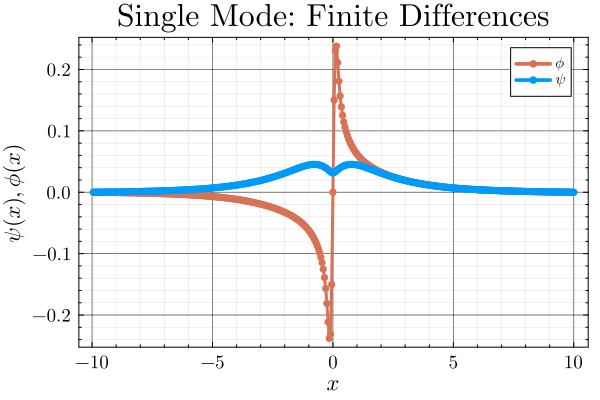

In [14]:
theme(:dao::Symbol)

myplot = plot(x, ϕ, markershape=:circle, lw=3, label=L"$\phi$")
myplot = plot!(x, ψ,
    markershape=:circle,
    lw=3,
    #xlims=(-1//2,1//2),
    legend=:best,
    label=L"$\psi$",
    title="Single Mode: Finite Differences",
    xlabel=L"$x$",
    ylabel=L"$\psi(x), \phi(x)$",
    titlefontsize=20,  # title
    tickfontsize=12,  # ticks
    legendfontsize=10, # legend
    yguidefontsize=15, # guides
    xguidefontsize=15
)

# savefig(myplot, "singlemode_tearing_soln.png")
myplot

In [15]:
#= 
To-Do:
1. get a measurement of Δ′
2. make more efficient with multithreading
3. use complex γ, iterate with Muller's method
4. turn into Matrix shooting method, shooting on ϕ
=#



instead of a linear algebra problem of finding eigenvalues and eigenvectors of matrix W, we could instead convert our (2n x 2n) matrix into a tensor via reverse matricization. Then take the n-mode product of that with the (n x 2) matrix where the 2 columns are $\psi$ and $\phi$. The mode-2 product gives us an (n x 2n^2) matrix which we can then perform SVD on. What will this give us? How do we interpret these results? 🤔

In [17]:
T = reshape(W, 2n, 2, n) # reverse matricization of W
T2 = reshape(T, 2, 2*n^2) # mode-2 matricization

2×320000 reshape(::BandedMatrix{Float64, Matrix{Float64}, Base.OneTo{Int64}}, 2, 320000) with eltype Float64:
 0.0  400.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0    0.0  0.0
 0.0    0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  400.0  0.0

In [22]:
svd(T2)

SVD{Float64, Float64, Matrix{Float64}, Vector{Float64}}
U factor:
2×2 Matrix{Float64}:
 -5.8765e-5  1.0
  1.0        5.8765e-5
singular values:
2-element Vector{Float64}:
 518804.44128368556
  19774.38122443593
Vt factor:
2×320000 Matrix{Float64}:
 1.08612e-15  -4.5308e-8  0.0  0.0  0.0  …  0.0  0.0  0.0  0.000771003  0.0
 1.67454e-18   0.0202282  0.0  0.0  0.0     0.0  0.0  0.0  1.18871e-6   0.0

In [63]:
U, S, V = svd(W, full=false);

In [114]:
r = 760 # Desired rank
U_r = U[:, 1:r]  # First r columns of U
S_r = Diagonal(S[1:r])  # First r singular values
V_r = V[:, 1:r];  # First r columns of V

In [115]:
W_r = U_r * S_r * V_r';

In [116]:
eigs_r = eigen(W_r);
iter_r = eigpos(eigs_r)
ψ_r = real.(eigs_r.vectors[:, iter][1:2:end]);
ϕ_r = real.(eigs_r.vectors[:, iter][2:2:end]);

# smallesteig = eigs.values[argmin(abs.(eigs.values))]
smallesteig_r = eigs_r.values[iter_r]

println("smallest eigenvalue: ", smallesteig_r)

smallest eigenvalue: -1.8497089737893003e-14 + 0.0im


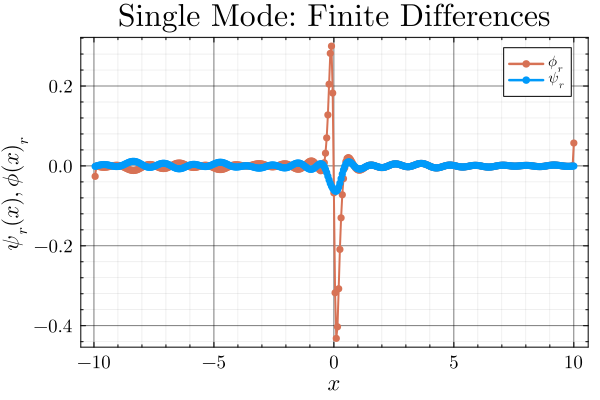

In [117]:
theme(:dao::Symbol)

myplot2 = plot(x, ϕ_r, markershape=:circle, lw=2, label=L"$\phi_{r}$")
myplot2 = plot!(x, ψ_r,
    markershape=:circle,
    lw=2,
    #xlims=(-1//2,1//2),
    legend=:best,
    label=L"$\psi_{r}$",
    title="Single Mode: Finite Differences",
    xlabel=L"$x$",
    ylabel=L"$\psi_{r}(x), \phi(x)_{r}$",
    titlefontsize=20,  # title
    tickfontsize=12,  # ticks
    legendfontsize=10, # legend
    yguidefontsize=15, # guides
    xguidefontsize=15
)

myplot2

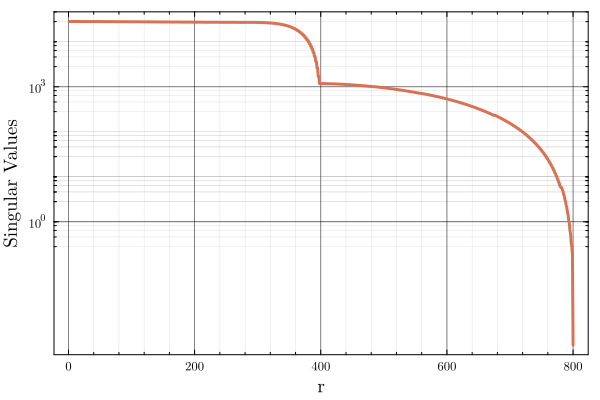

In [121]:
plot(1:800, S, 
    yscale=:log10,
    yaxis="Singular Values",
    xaxis="r",
    lw=3, 
    legend=false)

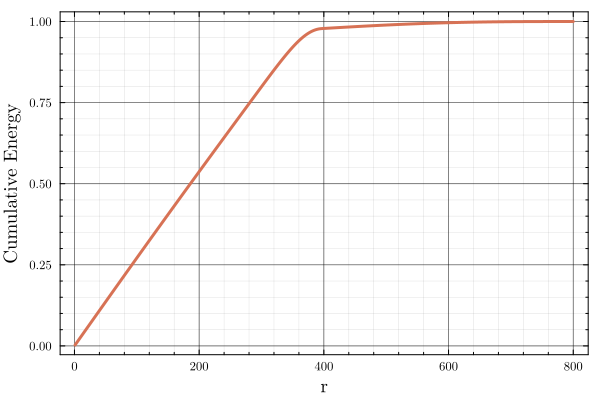

In [124]:
plot(1:800, cumsum(S)/sum(S), 
    #yscale=:log10,
    yaxis="Cumulative Energy",
    xaxis="r",
    lw=3, 
    legend=false)

so these plot look horrific for performing an SVD... we need MANY singular values to approximate our finite difference matrix. Which means that it holds little redundant information needed to solve our system. Which is actually good!